In [1]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time
import random
# import scipy.stats as stats
# from scipy.sparse import *
import pandas as pd
import os
import ast

from NMFC_h import *
from visualizingData import *

from numpy.linalg import inv, norm

In [2]:
FTICR_4_uni20_cli50 = np.load('FTICR_SAMPLED_DATA\\FTICR_4_uni20_cli50.npy', allow_pickle=True).item()
MASK4_uni20_cli50 = np.load('FTICR_SAMPLED_DATA\\MASK4_uni20_cli50.npy', allow_pickle=True).item()

M_dense_matrix = FTICR_4_uni20_cli50.toarray()
mask = MASK4_uni20_cli50.toarray()

In [3]:
def dimensionChange(M,k):
    return M[:k,:k] 

def dataNMaskChange(M_dense_matrix, mask, k):
    M_dense_matrix = dimensionChange(M_dense_matrix,k)
    mask= dimensionChange(mask,k)
    return M_dense_matrix, mask


In [4]:
M_dense_matrix, mask = dataNMaskChange(M_dense_matrix, mask, 10000)

In [5]:
mask.shape

(400, 10000)

In [6]:
norm(mask,'fro')

413.09805131469693

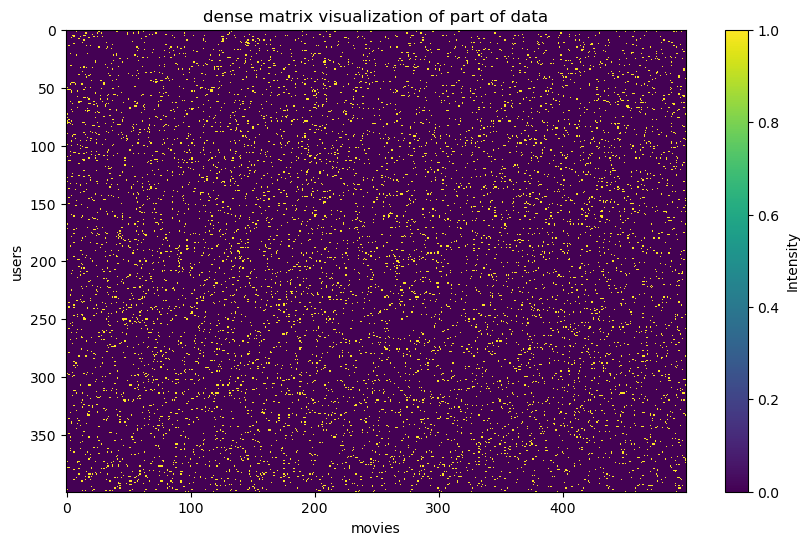

In [7]:
visualizeData(mask[:500,:500])

In [8]:



def NMFC(M, k,Sampled_mask, alpha, beta, max_iter, epsilon):
    '''
    Factorize a matrix M into two non-negative matrices X and Y using the Alternating Direction Method of Multipliers (ADMM) algorithm. As defined in the paper: doi: 10.1007/s11464-012-0194-5
    M: the matrix to factorize (with missing entries)
    k: the rank of the factorization
    alpha_factor: the factor to scale the alpha parameter
    alpha_choice: the choice of alpha parameter calculation, 1 or 2
    max_iter: the maximum number of iterations
    epsilon: the tolerance for the convergence criterion
    returns: W, H the factorized matrices, W: m x k, H: k x n
    '''

    A = projection_mask_operator(M, M)
    m, n = A.shape

    frobenius_A = norm(A, 'fro')

    # if alpha_choice == 1:
    #     alpha = alpha_factor * frobenius_A * max(m, n) / k
    #     beta = (n * alpha) / m

    # elif alpha_choice == 2:
    #     alpha = alpha_factor
    #     beta = alpha


    # print(f'alpha: {alpha}   beta: {beta}')

    gamma = 1.618

    # Initialize matrices X, Y, Z, U, V, Lambda, and Pi
    W = np.random.rand(m, k)
    H = np.random.rand(k, n)
    Z = A.copy()
    U = np.zeros(W.shape)
    V = np.zeros(H.shape)
    # lagrange multipliers
    Lambda = np.zeros(W.shape)
    Pi = np.zeros(H.shape)
    print('TOT HIER LUKT')


    #ADMM algorithm
    intermediate_error = []
    for i in range(max_iter):
        W_next = positive_projection((Z @ H.T + alpha * U - Lambda) @ inv(H @ H.T + alpha * np.eye(k)))

        H_next = positive_projection(inv(W_next.T @ W_next + beta * np.diag(np.ones(k))) @ (W_next.T @ Z + beta * V - Pi))

        Z_next = W_next @ H_next + projection_mask_operator(M - (W_next @ H_next), M)

        U_next = positive_projection(W_next + Lambda / alpha)
        V_next = positive_projection(H_next + Pi / beta)

        Lambda_next = Lambda + gamma * alpha * (W_next - U_next)
        Pi_next = Pi + gamma * beta * (H_next - V_next)

        f_k = norm(projection_mask_operator(W @ H - A, M), 'fro') / frobenius_A
        f_k1 = norm(projection_mask_operator(W_next @ H_next - A, M), 'fro') / frobenius_A
        intermediate_error.append(insampling_error_relative(M, W_next @ H_next, Sampled_mask))
        print(i, insampling_error_relative(M, W_next @ H_next, Sampled_mask))

        # Convergence check based on the relative change in Frobenius norm between iterations
        if i > 200:
          if np.abs(f_k1 - f_k) / np.maximum(1, np.abs(f_k)) <= epsilon:
              print('first', i)
              return W_next, H_next, intermediate_error

        # Convergence check based on the relative change in Frobenius norm of the projection operator
        elif f_k <= epsilon:
            print('second', i)

            return W_next, H_next, intermediate_error

        W, H, Z, U, V, Lambda, Pi = W_next, H_next, Z_next, U_next, V_next, Lambda_next, Pi_next
    print('convergence criteria not met')

    return W, H, intermediate_error

In [9]:




M = M_dense_matrix
alpha= 1e4
beta = 1e4
max_iter=10
epsilon=1e-7
# taking minimum dimension and 10% of that for preferred rank
k = round(min(mask.shape)*.1)

W, H, intermediate_error = NMFC(M, k,mask, alpha, beta, max_iter, epsilon)



TOT HIER LUKT
0 0.43786272088058253
1 0.3347328828280645
2 0.27399104600855856
3 0.2313064091843803
4 0.19960965931350985
5 0.17552077761738005
6 0.1569011962441825
7 0.14228006406175994
8 0.13062942848314713
9 0.12120197955775246
convergence criteria not met


In [12]:
def errorPlot(errors):
    errors = np.array(errors)

    # Create a plot
    plt.figure()
    plt.plot(errors, marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.title("Error decrease")
    plt.xlabel("Iteration")
    plt.ylabel("Error")

    # Show legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

In [13]:
intermediate_error

[0.43786272088058253,
 0.3347328828280645,
 0.27399104600855856,
 0.2313064091843803,
 0.19960965931350985,
 0.17552077761738005,
 0.1569011962441825,
 0.14228006406175994,
 0.13062942848314713,
 0.12120197955775246]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


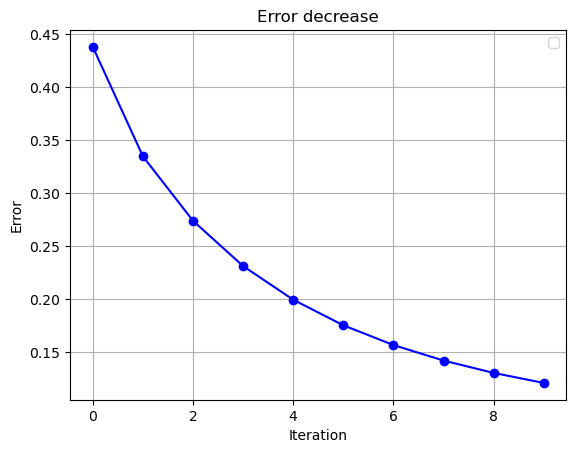

In [14]:
errorPlot(intermediate_error)

In [15]:
general_error_relative(M,W@H)*100

384.59168288121623

In [16]:
insampling_error_relative(M*mask,W@H,mask)*100

12.120197955775245

In [17]:
out_of_sample_error_relative(M,W@H,mask)*100

384.59168288121623

In [ ]:
# sparsity op H
